## Using CSky

Following Mike Richman's example, 01_getting_started.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import histlite as hl
import csky as cy

%matplotlib inline

In [2]:
timer = cy.timing.Timer()
time = timer.time

In [7]:
? cy.selections.GFUDataSpecs.gfu_3yr

Reading in data. Taken directly from example nb

Common datasets for tracks: (GFU?)
* `cy.selections.PSDataSpecs.ps_7yr` -- Stefan's 7yr dataset
* `cy.selections.GFUDataSpecs.gfu_3yr` -- GFU subset used for TXS analysis
* `cy.selections.NTDataSpecs.nt_8yr` -- Northern tracks
* `cy.selections.PSDataSpecs.ps_10yr` -- Tessa's 10yr dataset

In [3]:
with time('ana setup (from scratch)'):
    ana = cy.get_analysis(cy.selections.mrichman_repo, cy.selections.MESEDataSpecs.mesc_7yr_dnn)

Setting up Analysis for:
MESC_2010_2016_DNN
Setting up MESC_2010_2016_DNN...
Reading /data/user/mrichman/data/analyses/mese/current/mese_cascades_MC_2013_dnn.npy ...
Reading /data/user/mrichman/data/analyses/mese/current/mese_cascades_2010_2016_dnn.npy ...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.

0:00:12.850715 elapsed.


In [92]:
print(cy.CONF)

cy.CONF['ana'] = ana
#can incr number of cpus here
#cy.CONF['mp_cpus'] = 3

{'mp_cpus': 1, 'ana': Analysis(keys=[MESC_2010_2016_DNN])}


MR: The hottest spot in my analysis was found at $(\alpha,\delta)=(271.23^\circ,7.78^\circ)$.  Let's get a trial runner for that position in the sky:

In [5]:
src = cy.sources(271.23, 7.78, deg=True)
tr = cy.get_trial_runner(src=src)

MR: `cy.sources(ra,dec,**kw)` is a convenience function for constructing `cy.utils.Sources(**kw)` instances.  If `ra` and `dec` are arrays, then stacking analysis will be performed.  If nonzero `extension` value(s) are given, Gaussian source extension is assumed.

JT: default extension is zero. Can also get weighting from this. deg is kw to convert to rad

MR: `cy.get_trial_runner(...)` is a powerful function for obtaining `cy.trial.TrialRunner` instances.  A *trial runner* is an object which is capable of working with "trials" (basically, event ensembles plus counts of "excluded" events pre-emptively counted as purely background, $S/B \to 0$).  Trial runners not only produce trials, but also invoke likelihood fitting machinery for them; run them in (parallelizable) batches; and perform batches specifically useful for estimating sensitivities and discovery potentials.  They also provide an interface for converting between event rates and fluxes/fluences.

### Background Characterization

MR: The first step in most point source analyses is to characterize the background by running scrambled trials.  In csky, this is done as follows:

In [6]:
with time('ps bg trials'):
    n_trials = 10000
    bg = cy.dists.Chi2TSD(tr.get_many_fits(n_trials))

Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   

0:01:41.897880 elapsed.


Performing a num of background trials. (Takes awhile with only one core.) 

MR:`Chi2TSD` stores the trials as well as a $\chi^2$ fit to the nonzero part of the TS distribution.  We can look at a barebones summary or a detailed one:

In [9]:
#print(bg)
print(bg.description)
#eta is a fit param for the chi-sq fxn

Chi2TSD from 10000 trials:
           eta = 0.582
          ndof = 1.087
           loc = 0.000
         scale = 1.071
Thresholds from trials:
        median = 0.044
       1 sigma = 1.43
       2 sigma = 4.80
       3 sigma = 10.24
       4 sigma = 17.80
       5 sigma = 27.49
Thresholds from fit:
        median = 0.048
       1 sigma = 1.43
       2 sigma = 4.80
       3 sigma = 10.24
       4 sigma = 17.80
       5 sigma = 27.49


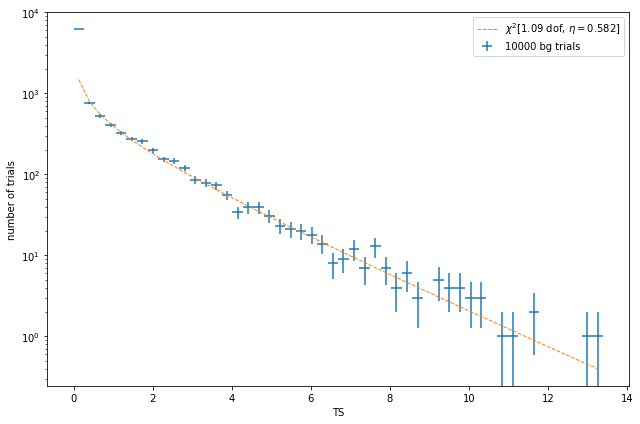

In [55]:
#plot bg distr
fig, ax = plt.subplots(figsize=(9,6)) #simplest way to return figure and axes

# csky uses histlite all over the place for PDF management
# the background distribution fit integrates with histlite as well
h = bg.get_hist(bins=50)
hl.plot1d(ax, h, crosses=True, #label='bg trials')
          label='{} bg trials'.format(bg.n_total))

# compare with the chi2 fit:
x = h.centers[0]
norm = h.integrate().values #normalization for chi-sq
ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--', #label=r'$\chi^2[%.2f$ dof]'%bg.ndof)
            label=r'$\chi^2[{:.2f}$ dof, $\eta={:.3f}]$'.format(bg.ndof, bg.eta))

# always label your plots, folks
ax.set_xlabel(r'TS')
ax.set_ylabel(r'number of trials')
ax.legend()
plt.tight_layout() #what does this do?

In [38]:
with time('ps sensitivity'):
    sens = tr.find_n_sig( #tr is trial runner, as defn above
        # ts, threshold
        bg.median(),
        # beta, fraction of trials which should exceed the threshold
        0.9,
        # n_inj step size for initial scan
        n_sig_step=5,
        # this many trials at a time
        batch_size=500,
        # tolerance, as estimated relative error
        tol=.05
    )

Start time: 2021-02-11 16:24:43.301711
Using 1 cores.
* Starting initial scan for 90% of 50 trials with TS >= 0.044...
  n_sig = 5.000 ... frac = 0.92000
* Generating batches of 500 trials...
n_trials | n_inj    0.00    2.00    4.00    6.00    8.00   10.00  |  n_sig(relative error)
500      |         51.4%   75.0%   88.0%   93.6%   98.2%   99.6%  |      4.586 (+/-  7.5%) [spline]
1000     |         52.0%   73.2%   87.2%   92.7%   97.2%   98.9%  |      4.876 (+/-  5.8%) [spline]
1500     |         52.1%   73.5%   87.2%   93.1%   96.9%   98.9%  |      4.799 (+/-  4.7%) [spline]
End time: 2021-02-11 16:26:56.396470
Elapsed time: 0:02:13.094759

0:02:13.095918 elapsed.


In [39]:
with time('ps discovery potential'):
    disc = tr.find_n_sig(bg.isf_nsigma(5), 0.5, n_sig_step=5, batch_size=500, tol=.05)
    #same fxn as before, 5 sigma 50% dp

Start time: 2021-02-11 16:27:53.535291
Using 1 cores.
* Starting initial scan for 50% of 50 trials with TS >= 27.488...
  n_sig = 5.000 ... frac = 0.00000
  n_sig = 10.000 ... frac = 0.10000
  n_sig = 15.000 ... frac = 0.26000
  n_sig = 20.000 ... frac = 0.40000
  n_sig = 25.000 ... frac = 0.82000
* Generating batches of 500 trials...
n_trials | n_inj    0.00   10.00   20.00   30.00   40.00   50.00  |  n_sig(relative error)
500      |          0.0%    4.4%   47.0%   91.0%   99.8%  100.0%  |     20.664 (+/-  2.2%) [spline]
End time: 2021-02-11 16:28:45.645552
Elapsed time: 0:00:52.110261

0:00:52.113080 elapsed.


Now `sens` and `disc` are `dict` objects including various information about the calculation, as well as the result under the key `n_sig`:

In [43]:
print(sens['n_sig'], disc['n_sig'])
#print(sens) #lots of information here
#print(disc)

4.798524403588972 20.663749932004993


MR: So far, we've just found the Poisson event rates that correspond to the sensitivity and discovery potential fluxes.  These can be converted to fluxes as follows:

In [45]:
fmt = '{:.3e}  TeV/cm2/s @ 100 TeV'
# either the number of events or the whole dict will work
print('Sensitivity flux: ',fmt.format(tr.to_E2dNdE(sens, E0=100, unit=1e3)))
print('Disc potential flux: ',fmt.format(tr.to_E2dNdE(disc['n_sig'], E0=100, unit=1e3)))

Sensitivity flux:  4.746e-12  TeV/cm2/s @ 100 TeV
Disc potential flux:  2.044e-11  TeV/cm2/s @ 100 TeV


### Test for fit bias

One powerful test of analysis readiness is to demonstrate that we can properly fit the parameters of an injected signal.  For this we start by getting some batches of signal trials:

In [46]:
n_sigs = np.r_[:101:10] #simple way to build arr quickly
with time('ps fit bias trials'):
    trials = [tr.get_many_fits(100, n_sig=n_sig, logging=False, seed=n_sig) for n_sig in n_sigs]


0:00:18.173873 elapsed.


In [75]:
#add true number of injected for bookkeeping
for (n_sig, t) in zip(n_sigs, trials):
    t['ntrue'] = np.repeat(n_sig, len(t))
allt = cy.utils.Arrays.concatenate(trials) #concatenate trial batches
allt 

Arrays(1100 items | columns: gamma, ns, ntrue, ts)

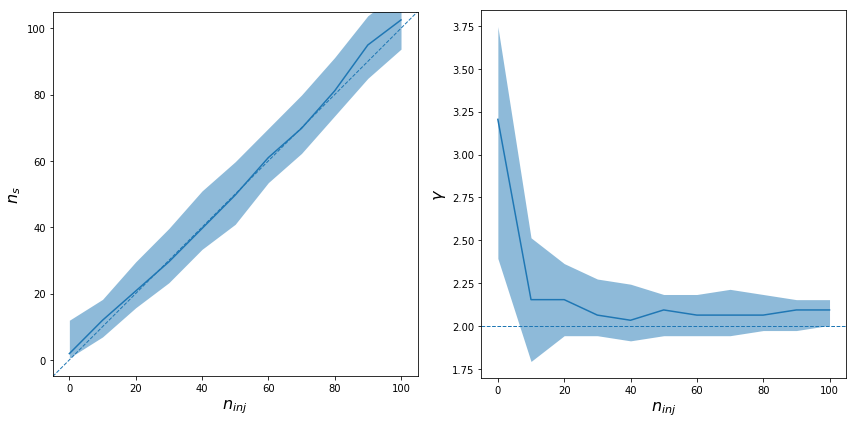

In [81]:
#Make plots!
fig, axs = plt.subplots(1, 2, figsize=(12,6))

dns = np.mean(np.diff(n_sigs))
ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)
expect_gamma = tr.sig_injs[0].flux[0].gamma

ax = axs[0]
h = hl.hist((allt.ntrue, allt.ns), bins=(ns_bins, 100))
hl.plot1d(ax, h.contain_project(1),errorbands=True, drawstyle='default')

lim = ns_bins[[0, -1]]
ax.set_xlim(ax.set_ylim(lim))
ax.plot(lim, lim, **expect_kw) #plot y=x line
ax.set_aspect('equal')

ax = axs[1]
h = hl.hist((allt.ntrue, allt.gamma), bins=(ns_bins, 100))
hl.plot1d(ax, h.contain_project(1),errorbands=True, drawstyle='default')
ax.axhline(expect_gamma, **expect_kw) #expected gamma line: gamma=2
ax.set_xlim(axs[0].get_xlim())

for ax in axs:
    ax.set_xlabel(r'$n_{inj}$', fontsize=16)
    #ax.grid()

axs[0].set_ylabel(r'$n_s$', fontsize=16)
axs[1].set_ylabel(r'$\gamma$', fontsize=16)

plt.tight_layout()

### Results

In [82]:
print(tr.format_result(tr.get_one_fit(TRUTH=True)))

TS                  9.143492682999423
ns                  32.296582725805045
gamma               2.9952806162350294


Ok, now finally, we use the pre-computed `bg` to calculate the p-value:

In [88]:
result = ts, ns, gamma = tr.get_one_fit(TRUTH=True)
print(result)

[9.143492682999423, 32.296582725805045, 2.9952806162350294]


In [89]:
print('p = {:.2e} ({:.2f} sigma)'.format(bg.sf(ts), bg.sf_nsigma(ts)))

p = 2.36e-03 (2.83 sigma)


## All Sky Scan

In many analyses, we aren't just interested in specific sky coordinates, but instead a scan over the whole sky.  In csky we can do this using a `cy.trial.SkyScanTrialRunner`, obtained like so:

In [93]:
sstr = cy.get_sky_scan_trial_runner(mp_scan_cpus=1, nside=32)

In [94]:
with time('ps all-sky scan'):
    scan = sstr.get_one_scan(TRUTH=True, logging=True)

Scanning 12288 locations using 1 cores:
      12288/12288 coordinates complete.   

0:01:44.211049 elapsed.


In [95]:
scan.shape #what the scan looks like

(4, 12288)

The second axis is npix for the selected healpy nside.  The first axis has items $(-\log_{10}(p),\text{TS},n_s,\gamma)$.  In this example we haven't bothered to characterize the background in detail, so the `scan[0]` is simply a copy of `scan[1]`.  To obtain proper p-values, pass an argument `get_sky_scan_trial_runner(..., ts_to_p=[function])`, where `[function]` should accept `dec[radians],ts` and return `p`, typically by using `cy.dists.ts_to_p`.

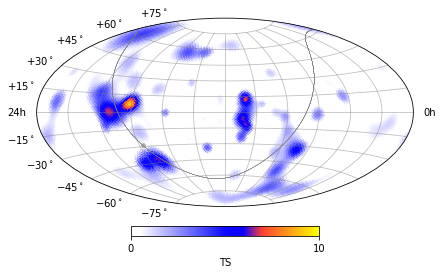

In [96]:
#plot of all sky scan!
fig, ax = plt.subplots (subplot_kw=dict (projection='aitoff'))
sp = cy.plotting.SkyPlotter(pc_kw=dict(cmap=cy.plotting.skymap_cmap, vmin=0, vmax=10))
mesh, cb = sp.plot_map(ax, scan[1], n_ticks=2)
kw = dict(color='.5', alpha=.5)
sp.plot_gp(ax, lw=.5, **kw)
sp.plot_gc(ax, **kw)
ax.grid(**kw)
cb.set_label(r'TS')
plt.tight_layout()

### Template analysis - ?

csky provides two types of template analysis: space-only templates, and per-pixel energy-binned spectra.  In the former, more common type, we provide a space-only healpix map describing the signal distribution across the sky.  My `mrichman_repo` provides the *Fermi*-LAT $\pi^0$-decay template:

In [97]:
pi0_map = cy.selections.mrichman_repo.get_template ('Fermi-LAT_pi0_map')

Reading /data/user/mrichman/data/analyses/templates/Fermi-LAT_pi0_map.npy ...


The desired template analysis can be expressed as a configuration dict, which will ultimately be overlayed on top of `cy.CONF`:

In [99]:
pi0_conf = {
    # desired template
    'template': pi0_map,
    # desired baseline spectrum
    'flux':     cy.hyp.PowerLawFlux(2.5),
    # desired fixed spectrum in likelihood
    'fitter_args': dict(gamma=2.5),
    # use signal subtracting likelihood
    'sigsub': True,
    # fastest construction:
    # weight from acceptance parameterization rather
    # than pixel-by-pixel directly from MC
    'fast_weight': True,
    # cache angular-resolution-smeared maps to disk
   # 'dir': cy.utils.ensure_dir('{}/templates/pi0'.format(ana_dir))
}

In [100]:
with time('pi0 template construction'):
    pi0_tr = cy.get_trial_runner(pi0_conf)

MESC_2010_2016_DNN        | Acceptance weighting complete.                    
MESC_2010_2016_DNN        | Smearing complete.                              

0:00:17.409861 elapsed.


`mrichman_repo` also provides the KRAγ templates: (diff decay?)

In [101]:
krag5_map, krag5_energy_bins = cy.selections.mrichman_repo.get_template(
    'KRA-gamma_5PeV_maps_energies', per_pixel_flux=True)

Reading /data/user/mrichman/data/analyses/templates/KRA-gamma_5PeV_maps_energies.tuple.npy ...


In [102]:
krag5_conf = {
    'template': krag5_map,
    'bins_energy': krag5_energy_bins,
    'fitter_args': dict(gamma=2.5),
    'update_bg' : True,
    'sigsub': True,
    #'dir': cy.utils.ensure_dir('{}/templates/kra'.format(ana_dir))
}

In [103]:
with time('KRAγ5 template construction'):
    krag5_tr = cy.get_trial_runner(krag5_conf)

MESC_2010_2016_DNN        | Acceptance weighting complete.                    
MESC_2010_2016_DNN        | Smearing complete.                              

0:00:30.054092 elapsed.


### Background characterization

In [104]:
with time('pi0 bg trials'):
    n_trials = 10000
    pi0_bg = cy.dists.Chi2TSD(pi0_tr.get_many_fits(n_trials))

Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   

0:01:07.277574 elapsed.


In [105]:
with time('KRAγ5 bg trials'):
    n_trials = 10000
    krag5_bg = cy.dists.Chi2TSD(krag5_tr.get_many_fits(n_trials))

Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   

0:00:30.731071 elapsed.


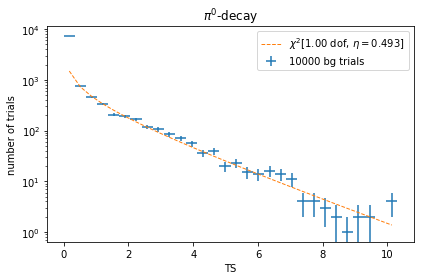

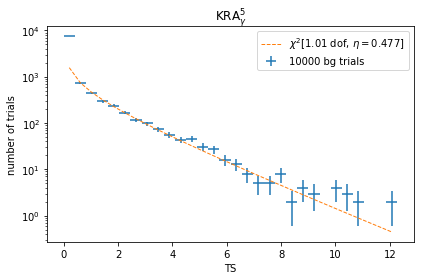

In [106]:
bgs = pi0_bg, krag5_bg
titles = '$\pi^0$-decay', 'KRA$_\gamma^5$'
for (b, title) in zip(bgs, titles):
    fig, ax = plt.subplots()
    h = b.get_hist(bins=30)
    hl.plot1d(ax, h, crosses=True,
              label='{} bg trials'.format(bg.n_total))
    x = h.centers[0]
    norm = h.integrate().values
    ax.semilogy(x, norm * b.pdf(x), lw=1, ls='--',
                label=r'$\chi^2[{:.2f}$ dof, $\eta={:.3f}]$'.format(b.ndof, b.eta))
    ax.set_xlabel(r'TS')
    ax.set_ylabel(r'number of trials')
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()

Sensitivity and Discovery Potential: same as for pt source above 

In [107]:
with time('pi0 sensitivity'):
    pi0_sens = pi0_tr.find_n_sig(pi0_bg.median(), 0.9, n_sig_step=10, batch_size=500, tol=.05)

Start time: 2021-02-11 17:26:31.391257
Using 1 cores.
* Starting initial scan for 90% of 50 trials with TS >= 0.000...
  n_sig = 10.000 ... frac = 0.68000
  n_sig = 20.000 ... frac = 0.76000
  n_sig = 30.000 ... frac = 0.90000
* Generating batches of 500 trials...
n_trials | n_inj    0.00   12.00   24.00   36.00   48.00   60.00  |  n_sig(relative error)
500      |         49.6%   68.0%   81.8%   92.6%   95.8%   99.2%  |     32.039 (+/-  5.3%) [spline]
1000     |         50.1%   67.8%   82.6%   91.6%   96.2%   99.0%  |     33.214 (+/-  3.4%) [spline]
End time: 2021-02-11 17:35:25.028649
Elapsed time: 0:08:53.637392

0:08:53.638464 elapsed.


In [108]:
with time('pi0 discovery potential'):
    pi0_disc = pi0_tr.find_n_sig(pi0_bg.isf_nsigma(5), 0.5, n_sig_step=20, batch_size=500, tol=.05)

Start time: 2021-02-11 17:35:25.043092
Using 1 cores.
* Starting initial scan for 50% of 50 trials with TS >= 25.114...
  n_sig = 20.000 ... frac = 0.00000
  n_sig = 40.000 ... frac = 0.00000
  n_sig = 60.000 ... frac = 0.00000
  n_sig = 80.000 ... frac = 0.00000
  n_sig = 100.000 ... frac = 0.16000
  n_sig = 120.000 ... frac = 0.26000
  n_sig = 140.000 ... frac = 0.38000
  n_sig = 160.000 ... frac = 0.56000
* Generating batches of 500 trials...
n_trials | n_inj    0.00   64.00  128.00  192.00  256.00  320.00  |  n_sig(relative error)
500      |          0.0%    0.8%   27.6%   79.4%   94.0%   97.2%  |    154.883 (+/-  1.0%) [spline]
End time: 2021-02-11 17:40:28.943822
Elapsed time: 0:05:03.900730

0:05:03.908239 elapsed.


In [109]:
with time('KRAγ5 sensitivity'):
    krag5_sens = krag5_tr.find_n_sig(krag5_bg.median(), 0.9, n_sig_step=10, batch_size=500, tol=.05)

Start time: 2021-02-11 17:40:28.952703
Using 1 cores.
* Starting initial scan for 90% of 50 trials with TS >= 0.000...
  n_sig = 10.000 ... frac = 0.72000
  n_sig = 20.000 ... frac = 0.90000
* Generating batches of 500 trials...
n_trials | n_inj    0.00    8.00   16.00   24.00   32.00   40.00  |  n_sig(relative error)
500      |         47.4%   73.2%   83.8%   94.2%   97.6%   99.4%  |     20.226 (+/-  4.2%) [spline]
End time: 2021-02-11 17:47:06.433730
Elapsed time: 0:06:37.481027

0:06:37.482202 elapsed.


In [110]:
with time('KRAγ5 discovery potential'):
    krag5_disc = krag5_tr.find_n_sig(krag5_bg.isf_nsigma(5), 0.5, n_sig_step=20, batch_size=500, tol=.05)

Start time: 2021-02-11 17:47:06.443626
Using 1 cores.
* Starting initial scan for 50% of 50 trials with TS >= 24.049...
  n_sig = 20.000 ... frac = 0.00000
  n_sig = 40.000 ... frac = 0.00000
  n_sig = 60.000 ... frac = 0.10000
  n_sig = 80.000 ... frac = 0.38000
  n_sig = 100.000 ... frac = 0.66000
* Generating batches of 500 trials...
n_trials | n_inj    0.00   40.00   80.00  120.00  160.00  200.00  |  n_sig(relative error)
500      |          0.0%    2.6%   38.4%   92.8%   99.6%  100.0%  |     88.509 (+/-  1.5%) [spline]
End time: 2021-02-11 17:54:06.134117
Elapsed time: 0:06:59.690491

0:06:59.694263 elapsed.


In [111]:
print('pi0-decay: ')
print('   Sensitivity: ',fmt.format(pi0_tr.to_E2dNdE(pi0_sens, E0=100, unit=1e3)))
print('   Discovery potential: ',fmt.format(pi0_tr.to_E2dNdE(pi0_disc, E0=100, unit=1e3)))
print('KRAγ: ')
print('   Sensitivity: {} x KRAγ5'.format(krag5_tr.to_model_norm(krag5_sens, E0=100, unit=1e3)))
print('   Discovery potential: {} x KRAγ5'.format(krag5_tr.to_model_norm(krag5_disc, E0=100, unit=1e3)))

pi0-decay: 
   Sensitivity:  2.263e-11  TeV/cm2/s @ 100 TeV
   Discovery potential:  1.055e-10  TeV/cm2/s @ 100 TeV
KRAγ: 
   Sensitivity: 0.5503836743434186 x KRAγ5
   Discovery potential: 2.408461313101727 x KRAγ5
